<a href="https://colab.research.google.com/github/aricahyasaputra/machine-learning-course-assigment/blob/main/Minggu%209%20Neural%20Networks/Tugas_Minggu_9_Chapter_3_Linear_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==0.17.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Linear Regression Implementation from Scratch
:label:`sec_linear_scratch`

Now that you understand the key ideas behind linear regression,
we can begin to work through a hands-on implementation in code.
In this section, (**we will implement the entire method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer.**)
While modern deep learning frameworks can automate nearly all of this work,
implementing things from scratch is the only way
to make sure that you really know what you are doing.
Moreover, when it comes time to customize models,
defining our own layers or loss functions,
understanding how things work under the hood will prove handy.
In this section, we will rely only on tensors and auto differentiation.
Afterwards, we will introduce a more concise implementation,
taking advantage of bells and whistles of deep learning frameworks.


In [2]:
%matplotlib inline
import random
import tensorflow as tf
from d2l import tensorflow as d2l

## Generating the Dataset

To keep things simple, we will [**construct an artificial dataset
according to a linear model with additive noise.**]
Our task will be to recover this model's parameters
using the finite set of examples contained in our dataset.
We will keep the data low-dimensional so we can visualize it easily.
In the following code snippet, we generate a dataset
containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

(**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and**) our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**)

You could think of $\epsilon$ as capturing potential
measurement errors on the features and labels.
We will assume that the standard assumptions hold and thus
that $\epsilon$ obeys a normal distribution with mean of 0.
To make our problem easy, we will set its standard deviation to 0.01.
The following code generates our synthetic dataset.


In [3]:
def synthetic_data(w, b, num_examples):  
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [4]:
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Note that [**each row in `features` consists of a 2-dimensional data example
and that each row in `labels` consists of a 1-dimensional label value (a scalar).**]


In [5]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([-0.16280864 -0.7303712 ], shape=(2,), dtype=float32) 
label: tf.Tensor([6.3508344], shape=(1,), dtype=float32)


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


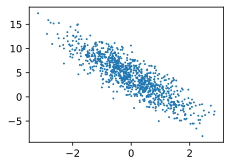

In [6]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

## Reading the Dataset

Recall that training models consists of
making multiple passes over the dataset,
grabbing one minibatch of examples at a time,
and using them to update our model.
Since this process is so fundamental
to training machine learning algorithms,
it is worth defining a utility function
to shuffle the dataset and access it in minibatches.

In the following code, we [**define the `data_iter` function**] (~~that~~)
to demonstrate one possible implementation of this functionality.
The function (**takes a batch size, a matrix of features,
and a vector of labels, yielding minibatches of the size `batch_size`.**)
Each minibatch consists of a tuple of features and labels.


In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In general, note that we want to use reasonably sized minibatches
to take advantage of the GPU hardware,
which excels at parallelizing operations.
Because each example can be fed through our models in parallel
and the gradient of the loss function for each example can also be taken in parallel,
GPUs allow us to process hundreds of examples in scarcely more time
than it might take to process just a single example.

To build some intuition, let us read and print
the first small batch of data examples.
The shape of the features in each minibatch tells us
both the minibatch size and the number of input features.
Likewise, our minibatch of labels will have a shape given by `batch_size`.


In [8]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[-0.23016247  0.5351826 ]
 [-1.5050676  -1.31289   ]
 [-1.2924241   1.8181756 ]
 [ 0.12086978  0.6927019 ]
 [ 1.3733481  -0.79787904]
 [ 0.83560425 -0.63733286]
 [ 1.750993   -1.0811301 ]
 [-0.7076834   1.3565054 ]
 [ 2.029592    1.434988  ]
 [-0.2641833   0.9746737 ]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[ 1.9105614 ]
 [ 5.642967  ]
 [-4.576551  ]
 [ 2.0879896 ]
 [ 9.660497  ]
 [ 8.044098  ]
 [11.366286  ]
 [-1.8318508 ]
 [ 3.374434  ]
 [ 0.36660406]], shape=(10, 1), dtype=float32)


As we run the iteration, we obtain distinct minibatches
successively until the entire dataset has been exhausted (try this).
While the iteration implemented above is good for didactic purposes,
it is inefficient in ways that might get us in trouble on real problems.
For example, it requires that we load all the data in memory
and that we perform lots of random memory access.
The built-in iterators implemented in a deep learning framework
are considerably more efficient and they can deal
with both data stored in files and data fed via data streams.


## Initializing Model Parameters

[**Before we can begin optimizing our model's parameters**] by minibatch stochastic gradient descent,
(**we need to have some parameters in the first place.**)
In the following code, we initialize weights by sampling
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01, and setting the bias to 0.


In [9]:
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01),
                trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

After initializing our parameters,
our next task is to update them until
they fit our data sufficiently well.
Each update requires taking the gradient
of our loss function with respect to the parameters.
Given this gradient, we can update each parameter
in the direction that may reduce the loss.

Since nobody wants to compute gradients explicitly
(this is tedious and error prone),
we use automatic differentiation,
as introduced in :numref:`sec_autograd`, to compute the gradient.


## Defining the Model

Next, we must [**define our model,
relating its inputs and parameters to its outputs.**]
Recall that to calculate the output of the linear model,
we simply take the matrix-vector dot product
of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.
Note that below $\mathbf{Xw}$  is a vector and $b$ is a scalar.
Recall the broadcasting mechanism as described in :numref:`subsec_broadcasting`.
When we add a vector and a scalar,
the scalar is added to each component of the vector.


In [10]:
def linreg(X, w, b):  
    """The linear regression model."""
    return tf.matmul(X, w) + b

## Defining the Loss Function

Since [**updating our model requires taking
the gradient of our loss function,**]
we ought to (**define the loss function first.**)
Here we will use the squared loss function
as described in :numref:`sec_linear_regression`.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [11]:
def squared_loss(y_hat, y): 
    """Squared loss."""
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

## Defining the Optimization Algorithm

As we discussed in :numref:`sec_linear_regression`,
linear regression has a closed-form solution.
However, this is not a book about linear regression:
it is a book about deep learning.
Since none of the other models that this book introduces
can be solved analytically, we will take this opportunity to introduce your first working example of
minibatch stochastic gradient descent.
Despite linear regression has a closed-form solution, other models in this book don't. Here we introduce minibatch stochastic gradient descent.

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.
The following code applies the minibatch stochastic gradient descent update,
given a set of parameters, a learning rate, and a batch size.
The size of the update step is determined by the learning rate `lr`.
Because our loss is calculated as a sum over the minibatch of examples,
we normalize our step size by the batch size (`batch_size`),
so that the magnitude of a typical step size
does not depend heavily on our choice of the batch size.


In [12]:
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)

## Training

Now that we have all of the parts in place,
we are ready to [**implement the main training loop.**]
It is crucial that you understand this code
because you will see nearly identical training loops
over and over again throughout your career in deep learning.

In each iteration, we will grab a minibatch of training examples,
and pass them through our model to obtain a set of predictions.
After calculating the loss, we initiate the backwards pass through the network,
storing the gradients with respect to each parameter.
Finally, we will call the optimization algorithm `sgd`
to update the model parameters.

In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
(assuming that the number of examples is divisible by the batch size).
The number of epochs `num_epochs` and the learning rate `lr` are both hyperparameters,
which we set here to 3 and 0.03, respectively.
Unfortunately, setting hyperparameters is tricky
and requires some adjustment by trial and error.
We elide these details for now but revise them
later in
:numref:`chap_optimization`.


In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [14]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on l with respect to [`w`, `b`]
        dw, db = g.gradient(l, [w, b])
        # Update parameters using their gradient
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')

epoch 1, loss 0.031368
epoch 2, loss 0.000107
epoch 3, loss 0.000048


In this case, because we synthesized the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can [**evaluate our success in training
by comparing the true parameters
with those that we learned**] through our training loop.
Indeed they turn out to be very close to each other.


In [15]:
print(f'error in estimating w: {true_w - tf.reshape(w, true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: [ 0.00032663 -0.00100303]
error in estimating b: [-0.00047064]


Note that we should not take it for granted
that we are able to recover the parameters perfectly.
However, in machine learning, we are typically less concerned
with recovering true underlying parameters,
and more concerned with parameters that lead to highly accurate prediction.
Fortunately, even on difficult optimization problems,
stochastic gradient descent can often find remarkably good solutions,
owing partly to the fact that, for deep networks,
there exist many configurations of the parameters
that lead to highly accurate prediction.


## Summary

* We saw how a deep network can be implemented and optimized from scratch, using just tensors and auto differentiation, without any need for defining layers or fancy optimizers.
* This section only scratches the surface of what is possible. In the following sections, we will describe additional models based on the concepts that we have just introduced and learn how to implement them more concisely.


# Concise Implementation of Linear Regression
:label:`sec_linear_concise`

Broad and intense interest in deep learning for the past several years
has inspired companies, academics, and hobbyists
to develop a variety of mature open source frameworks
for automating the repetitive work of implementing
gradient-based learning algorithms.
In :numref:`sec_linear_scratch`, we relied only on
(i) tensors for data storage and linear algebra;
and (ii) auto differentiation for calculating gradients.
In practice, because data iterators, loss functions, optimizers,
and neural network layers
are so common, modern libraries implement these components for us as well.

In this section, (**we will show you how to implement
the linear regression model**) from :numref:`sec_linear_scratch`
(**concisely by using high-level APIs**) of deep learning frameworks.


## Generating the Dataset

To start, we will generate the same dataset as in :numref:`sec_linear_scratch`.


In [16]:
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [17]:
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

## Reading the Dataset

Rather than rolling our own iterator,
we can [**call upon the existing API in a framework to read data.**]
We pass in `features` and `labels` as arguments and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).


In [18]:
def load_array(data_arrays, batch_size, is_train=True): 
    """Construct a TensorFlow data iterator."""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

In [19]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

Now we can use `data_iter` in much the same way as we called
the `data_iter` function in :numref:`sec_linear_scratch`.
To verify that it is working, we can read and print
the first minibatch of examples.
Comparing with :numref:`sec_linear_scratch`,
here we use `iter` to construct a Python iterator and use `next` to obtain the first item from the iterator.


In [20]:
next(iter(data_iter))

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[ 0.43857205, -0.23930086],
        [ 0.47383082,  0.55768573],
        [-1.3863571 ,  0.06574073],
        [ 0.6265939 , -0.707853  ],
        [ 0.28932554,  1.7337036 ],
        [ 1.0063866 , -0.38974407],
        [ 0.14217311, -0.9720836 ],
        [-0.6838074 ,  0.8384975 ],
        [-0.0099813 ,  0.14504915],
        [ 0.03094158, -1.3588201 ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 5.893489  ],
        [ 3.24932   ],
        [ 1.1831776 ],
        [ 7.859075  ],
        [-1.1055853 ],
        [ 7.534088  ],
        [ 7.7954473 ],
        [-0.02079498],
        [ 3.6817713 ],
        [ 8.886059  ]], dtype=float32)>)

## Defining the Model

When we implemented linear regression from scratch
in :numref:`sec_linear_scratch`,
we defined our model parameters explicitly
and coded up the calculations to produce output
using basic linear algebra operations.
You *should* know how to do this.
But once your models get more complex,
and once you have to do this nearly every day,
you will be glad for the assistance.
The situation is similar to coding up your own blog from scratch.
Doing it once or twice is rewarding and instructive,
but you would be a lousy web developer
if every time you needed a blog you spent a month
reinventing the wheel.

For standard operations, we can [**use a framework's predefined layers,**]
which allow us to focus especially
on the layers used to construct the model
rather than having to focus on the implementation.
We will first define a model variable `net`,
which will refer to an instance of the `Sequential` class.
The `Sequential` class defines a container
for several layers that will be chained together.
Given input data, a `Sequential` instance passes it through
the first layer, in turn passing the output
as the second layer's input and so forth.
In the following example, our model consists of only one layer,
so we do not really need `Sequential`.
But since nearly all of our future models
will involve multiple layers,
we will use it anyway just to familiarize you
with the most standard workflow.

Recall the architecture of a single-layer network as shown in :numref:`fig_single_neuron`.
The layer is said to be *fully-connected*
because each of its inputs is connected to each of its outputs
by means of a matrix-vector multiplication.


In Keras, the fully-connected layer is defined in the `Dense` class. Since we only want to generate a single scalar output, we set that number to 1.

It is worth noting that, for convenience,
Keras does not require us to specify
the input shape for each layer.
So here, we do not need to tell Keras
how many inputs go into this linear layer.
When we first try to pass data through our model,
e.g., when we execute `net(X)` later,
Keras will automatically infer the number of inputs to each layer.
We will describe how this works in more detail later.


In [21]:
# `keras` is the high-level API for TensorFlow
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1))

## Initializing Model Parameters

Before using `net`, we need to (**initialize the model parameters,**)
such as the weights and bias in the linear regression model.
Deep learning frameworks often have a predefined way to initialize the parameters.
Here we specify that each weight parameter
should be randomly sampled from a normal distribution
with mean 0 and standard deviation 0.01.
The bias parameter will be initialized to zero.


The `initializers` module in TensorFlow provides various methods for model parameter initialization. The easiest way to specify the initialization method in Keras is when creating the layer by specifying `kernel_initializer`. Here we recreate `net` again.


In [22]:
initializer = tf.initializers.RandomNormal(stddev=0.01)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

The code above may look straightforward but you should note
that something strange is happening here.
We are initializing parameters for a network
even though Keras does not yet know
how many dimensions the input will have!
It might be 2 as in our example or it might be 2000.
Keras lets us get away with this because behind the scenes,
the initialization is actually *deferred*.
The real initialization will take place only
when we for the first time attempt to pass data through the network.
Just be careful to remember that since the parameters
have not been initialized yet,
we cannot access or manipulate them.


## Defining the Loss Function


The `MeanSquaredError` class computes the mean squared error (without the $1/2$ factor in :eqref:`eq_mse`).
By default it returns the average loss over examples.


In [23]:
loss = tf.keras.losses.MeanSquaredError()

## Defining the Optimization Algorithm


Minibatch stochastic gradient descent is a standard tool
for optimizing neural networks
and thus Keras supports it alongside a number of
variations on this algorithm in the `optimizers` module.
Minibatch stochastic gradient descent just requires that
we set the value `learning_rate`, which is set to 0.03 here.


In [24]:
trainer = tf.keras.optimizers.SGD(learning_rate=0.03)

## Training

You might have noticed that expressing our model through
high-level APIs of a deep learning framework
requires comparatively few lines of code.
We did not have to individually allocate parameters,
define our loss function, or implement minibatch stochastic gradient descent.
Once we start working with much more complex models,
advantages of high-level APIs will grow considerably.
However, once we have all the basic pieces in place,
[**the training loop itself is strikingly similar
to what we did when implementing everything from scratch.**]

To refresh your memory: for some number of epochs,
we will make a complete pass over the dataset (`train_data`),
iteratively grabbing one minibatch of inputs
and the corresponding ground-truth labels.
For each minibatch, we go through the following ritual:

* Generate predictions by calling `net(X)` and calculate the loss `l` (the forward propagation).
* Calculate gradients by running the backpropagation.
* Update the model parameters by invoking our optimizer.

For good measure, we compute the loss after each epoch and print it to monitor progress.


In [25]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        with tf.GradientTape() as tape:
            l = loss(net(X, training=True), y)
        grads = tape.gradient(l, net.trainable_variables)
        trainer.apply_gradients(zip(grads, net.trainable_variables))
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000248
epoch 2, loss 0.000096
epoch 3, loss 0.000097


Below, we [**compare the model parameters learned by training on finite data
and the actual parameters**] that generated our dataset.
To access parameters,
we first access the layer that we need from `net`
and then access that layer's weights and bias.
As in our from-scratch implementation,
note that our estimated parameters are
close to their ground-truth counterparts.


In [26]:
w = net.get_weights()[0]
print('error in estimating w', true_w - tf.reshape(w, true_w.shape))
b = net.get_weights()[1]
print('error in estimating b', true_b - b)

error in estimating w tf.Tensor([-0.00061488 -0.00106168], shape=(2,), dtype=float32)
error in estimating b [-0.0005517]


## Summary


* Using TensorFlow's high-level APIs, we can implement models much more concisely.
* In TensorFlow, the `data` module provides tools for data processing, the `keras` module defines a large number of neural network layers and common loss functions.
* TensorFlow's module `initializers` provides various methods for model parameter initialization.
* Dimensionality and storage are automatically inferred (but be careful not to attempt to access parameters before they have been initialized).


# The Image Classification Dataset
:label:`sec_fashion_mnist`

(The MNIST dataset is one of the widely used dataset for image classification, while it's too simple as a benchmark dataset. We will use the similar, but more complex Fashion-MNIST dataset)

One of the widely used dataset for image classification is the  MNIST dataset :cite:`LeCun.Bottou.Bengio.ea.1998`.
While it had a good run as a benchmark dataset,
even simple models by today's standards achieve classification accuracy over 95%,
making it unsuitable for distinguishing between stronger models and weaker ones.
Today, MNIST serves as more of sanity checks than as a benchmark.
To up the ante just a bit, we will focus our discussion in the coming sections
on the qualitatively similar, but comparatively complex Fashion-MNIST
dataset :cite:`Xiao.Rasul.Vollgraf.2017`, which was released in 2017.


In [27]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

d2l.use_svg_display()

## Reading the Dataset

We can [**download and read the Fashion-MNIST dataset into memory via the build-in functions in the framework.**]


In [28]:
mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


Fashion-MNIST consists of images from 10 categories, each represented
by 6000 images in the training dataset and by 1000 in the test dataset.
A *test dataset* (or *test set*) is used for evaluating  model performance and not for training.
Consequently the training set and the test set
contain 60000 and 10000 images, respectively.


In [29]:
len(mnist_train[0]), len(mnist_test[0])

(60000, 10000)

The height and width of each input image are both 28 pixels.
Note that the dataset consists of grayscale images, whose number of channels is 1.
For brevity, throughout this book
we store the shape of any image with height $h$ width $w$ pixels as $h \times w$ or ($h$, $w$).


In [30]:
mnist_train[0][0].shape

(28, 28)

[Two utility functions to visualize the dataset]

The images in Fashion-MNIST are associated with the following categories:
t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot.
The following function converts between numeric label indices and their names in text.


In [31]:
def get_fashion_mnist_labels(labels):  
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

We can now create a function to visualize these examples.


In [32]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

Here are [**the images and their corresponding labels**] (in text)
for the first few examples in the training dataset.


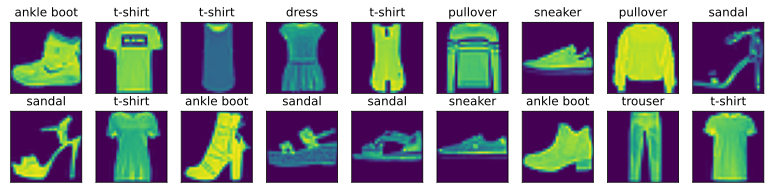

In [33]:
X = tf.constant(mnist_train[0][:18])
y = tf.constant(mnist_train[1][:18])
show_images(X, 2, 9, titles=get_fashion_mnist_labels(y));

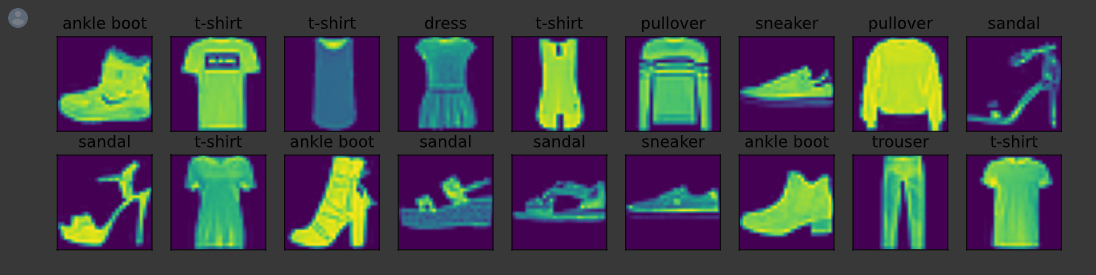

## Reading a Minibatch

To make our life easier when reading from the training and test sets,
we use the built-in data iterator rather than creating one from scratch.
Recall that at each iteration, a data iterator
[**reads a minibatch of data with size `batch_size` each time.**]
We also randomly shuffle the examples for the training data iterator.


In [34]:
batch_size = 256
train_iter = tf.data.Dataset.from_tensor_slices(
    mnist_train).batch(batch_size).shuffle(len(mnist_train[0]))

Let us look at the time it takes to read the training data.


In [35]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'0.20 sec'

## Putting All Things Together

Now we define [**the `load_data_fashion_mnist` function
that obtains and reads the Fashion-MNIST dataset.**]
It returns the data iterators for both the training set and validation set.
In addition, it accepts an optional argument to resize images to another shape.


In [36]:
def load_data_fashion_mnist(batch_size, resize=None):  
    """Download the Fashion-MNIST dataset and then load it into memory."""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # Divide all numbers by 255 so that all pixel values are between
    # 0 and 1, add a batch dimension at the last. And cast label to int32
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (
        tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    return (
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(
            batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(
            batch_size).map(resize_fn))

Below we test the image resizing feature of the `load_data_fashion_mnist` function
by specifying the `resize` argument.


In [37]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

(32, 64, 64, 1) <dtype: 'float32'> (32,) <dtype: 'int32'>


We are now ready to work with the Fashion-MNIST dataset in the sections that follow.

## Summary

* Fashion-MNIST is an apparel classification dataset consisting of images representing 10 categories. We will use this dataset in subsequent sections and chapters to evaluate various classification algorithms.
* We store the shape of any image with height $h$ width $w$ pixels as $h \times w$ or ($h$, $w$).
* Data iterators are a key component for efficient performance. Rely on well-implemented data iterators that exploit high-performance computing to avoid slowing down your training loop.


# Implementation of Softmax Regression from Scratch
:label:`sec_softmax_scratch`

(**Just as we implemented linear regression from scratch, we believe that**)
softmax regression
is similarly fundamental and
(**you ought to know the gory details of**) (softmax regression) and how to implement it yourself.
We will work with the Fashion-MNIST dataset, just introduced in :numref:`sec_fashion_mnist`,
setting up a data iterator with batch size 256.


In [38]:
import tensorflow as tf
from IPython import display
from d2l import tensorflow as d2l

In [39]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## Initializing Model Parameters

As in our linear regression example,
each example here will be represented by a fixed-length vector.
Each example in the raw dataset is a $28 \times 28$ image.
In this section, [**we will flatten each image,
treating them as vectors of length 784.**]
In the future, we will talk about more sophisticated strategies
for exploiting the spatial structure in images,
but for now we treat each pixel location as just another feature.

Recall that in softmax regression,
we have as many outputs as there are classes.
(**Because our dataset has 10 classes,
our network will have an output dimension of 10.**)
Consequently, our weights will constitute a $784 \times 10$ matrix
and the biases will constitute a $1 \times 10$ row vector.
As with linear regression, we will initialize our weights `W`
with Gaussian noise and our biases to take the initial value 0.


In [40]:
num_inputs = 784
num_outputs = 10

W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs),
                                 mean=0, stddev=0.01))
b = tf.Variable(tf.zeros(num_outputs))

## Defining the Softmax Operation

Before implementing the softmax regression model,
let us briefly review how the sum operator works
along specific dimensions in a tensor,
as discussed in :numref:`subseq_lin-alg-reduction` and :numref:`subseq_lin-alg-non-reduction`.
[**Given a matrix `X` we can sum over all elements (by default) or only
over elements in the same axis,**]
i.e., the same column (axis 0) or the same row (axis 1).
Note that if `X` is a tensor with shape (2, 3)
and we sum over the columns,
the result will be a vector with shape (3,).
When invoking the sum operator,
we can specify to keep the number of axes in the original tensor,
rather than collapsing out the dimension that we summed over.
This will result in a two-dimensional tensor with shape (1, 3).


In [41]:
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tf.reduce_sum(X, 0, keepdims=True), tf.reduce_sum(X, 1, keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

We are now ready to (**implement the softmax operation**).
Recall that softmax consists of three steps:
(i) we exponentiate each term (using `exp`);
(ii) we sum over each row (we have one row per example in the batch)
to get the normalization constant for each example;
(iii) we divide each row by its normalization constant,
ensuring that the result sums to 1.
Before looking at the code, let us recall
how this looks expressed as an equation:

(**
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$
**)

The denominator, or normalization constant,
is also sometimes called the *partition function*
(and its logarithm is called the log-partition function).
The origins of that name are in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))
where a related equation models the distribution
over an ensemble of particles.


In [42]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

As you can see, for any random input,
[**we turn each element into a non-negative number.
Moreover, each row sums up to 1,**]
as is required for a probability.


In [43]:
X = tf.random.normal((2, 5), 0, 1)
X_prob = softmax(X)
X_prob, tf.reduce_sum(X_prob, 1)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.7219689 , 0.08367839, 0.09883658, 0.0779622 , 0.01755401],
        [0.06885166, 0.12098564, 0.6955118 , 0.10308582, 0.01156512]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.0000001, 1.0000001], dtype=float32)>)

Note that while this looks correct mathematically,
we were a bit sloppy in our implementation
because we failed to take precautions against numerical overflow or underflow
due to large or very small elements of the matrix.

## Defining the Model

Now that we have defined the softmax operation,
we can [**implement the softmax regression model.**]
The below code defines how the input is mapped to the output through the network.
Note that we flatten each original image in the batch
into a vector using the `reshape` function
before passing the data through our model.


In [44]:
def net(X):
    return softmax(tf.matmul(tf.reshape(X, (-1, W.shape[0])), W) + b)

## Defining the Loss Function

Next, we need to implement the cross-entropy loss function,
as introduced in :numref:`sec_softmax`.
This may be the most common loss function
in all of deep learning because, at the moment,
classification problems far outnumber regression problems.

Recall that cross-entropy takes the negative log-likelihood
of the predicted probability assigned to the true label.
Rather than iterating over the predictions with a Python for-loop
(which tends to be inefficient),
we can pick all elements by a single operator.
Below, we [**create sample data `y_hat`
with 2 examples of predicted probabilities over 3 classes and their corresponding labels `y`.**]
With `y` we know that in the first example the first class is the correct prediction and
in the second example the third class is the ground-truth.
[**Using `y` as the indices of the probabilities in `y_hat`,**]
we pick the probability of the first class in the first example
and the probability of the third class in the second example.


In [45]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

Now we can (**implement the cross-entropy loss function**) efficiently with just one line of code.


In [46]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(
        y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

cross_entropy(y_hat, y)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.3025851, 0.6931472], dtype=float32)>

## Classification Accuracy

Given the predicted probability distribution `y_hat`,
we typically choose the class with the highest predicted probability
whenever we must output a hard prediction.
Indeed, many applications require that we make a choice.
Gmail must categorize an email into "Primary", "Social", "Updates", or "Forums".
It might estimate probabilities internally,
but at the end of the day it has to choose one among the classes.

When predictions are consistent with the label class `y`, they are correct.
The classification accuracy is the fraction of all predictions that are correct.
Although it can be difficult to optimize accuracy directly (it is not differentiable),
it is often the performance measure that we care most about,
and we will nearly always report it when training classifiers.

To compute accuracy we do the following.
First, if `y_hat` is a matrix,
we assume that the second dimension stores prediction scores for each class.
We use `argmax` to obtain the predicted class by the index for the largest entry in each row.
Then we [**compare the predicted class with the ground-truth `y` elementwise.**]
Since the equality operator `==` is sensitive to data types,
we convert `y_hat`'s data type to match that of `y`.
The result is a tensor containing entries of 0 (false) and 1 (true).
Taking the sum yields the number of correct predictions.


In [47]:
def accuracy(y_hat, y):  
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

We will continue to use the variables `y_hat` and `y`
defined before
as the predicted probability distributions and labels, respectively.
We can see that the first example's prediction class is 2
(the largest element of the row is 0.6 with the index 2),
which is inconsistent with the actual label, 0.
The second example's prediction class is 2
(the largest element of the row is 0.5 with the index of 2),
which is consistent with the actual label, 2.
Therefore, the classification accuracy rate for these two examples is 0.5.


In [48]:
accuracy(y_hat, y) / len(y)

0.5

[**Similarly, we can evaluate the accuracy for any model `net` on a dataset**]
that is accessed via the data iterator `data_iter`.


In [49]:
def evaluate_accuracy(net, data_iter):  
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

Here `Accumulator` is a utility class to accumulate sums over multiple variables.
In the above `evaluate_accuracy` function,
we create 2 variables in the `Accumulator` instance for storing both
the number of correct predictions and the number of predictions, respectively.
Both will be accumulated over time as we iterate over the dataset.


In [50]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

[**Because we initialized the `net` model with random weights,
the accuracy of this model should be close to random guessing,**]
i.e., 0.1 for 10 classes.


In [51]:
evaluate_accuracy(net, test_iter)

0.089

## Training

[**The training loop**]
for softmax regression should look strikingly familiar
if you read through our implementation
of linear regression in :numref:`sec_linear_scratch`.
Here we refactor the implementation to make it reusable.
First, we define a function to train for one epoch.
Note that `updater` is a general function to update the model parameters,
which accepts the batch size as an argument.
It can be either a wrapper of the `d2l.sgd` function
or a framework's built-in optimization function.


In [52]:
def train_epoch_ch3(net, train_iter, loss, updater):  
    """The training loop defined in Chapter 3."""
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras implementations for loss takes (labels, predictions)
            # instead of (predictions, labels) that users might implement
            # in this book, e.g. `cross_entropy` that we implemented above
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras loss by default returns the average loss in a batch
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

Before showing the implementation of the training function,
we define [**a utility class that plot data in animation.**]
Again, it aims to simplify code in the rest of the book.


In [53]:
class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

[~~The training function~~]
The following training function then
trains a model `net` on a training dataset accessed via `train_iter`
for multiple epochs, which is specified by `num_epochs`.
At the end of each epoch,
the model is evaluated on a testing dataset accessed via `test_iter`.
We will leverage the `Animator` class to visualize
the training progress.


In [54]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

As an implementation from scratch,
we [**use the minibatch stochastic gradient descent**] defined in :numref:`sec_linear_scratch`
to optimize the loss function of the model with a learning rate 0.1.


In [55]:
class Updater():  
    """For updating parameters using minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        d2l.sgd(self.params, grads, self.lr, batch_size)

updater = Updater([W, b], lr=0.1)

Now we [**train the model with 10 epochs.**]
Note that both the number of epochs (`num_epochs`),
and learning rate (`lr`) are adjustable hyperparameters.
By changing their values, we may be able
to increase the classification accuracy of the model.


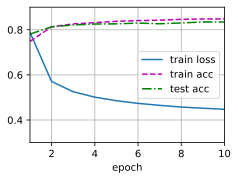

In [56]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## Prediction

Now that training is complete,
our model is ready to [**classify some images.**]
Given a series of images,
we will compare their actual labels
(first line of text output)
and the predictions from the model
(second line of text output).


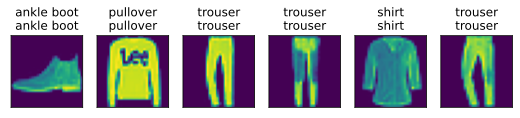

In [57]:
def predict_ch3(net, test_iter, n=6):  
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

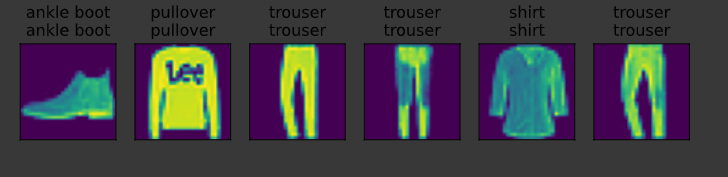

## Summary

* With softmax regression, we can train models for multiclass classification.
* The training loop of softmax regression is very similar to that in linear regression: retrieve and read data, define models and loss functions, then train models using optimization algorithms. As you will soon find out, most common deep learning models have similar training procedures.

